## Fake News Classifier using LSTM

In this notebook we will talk about how one can create an NLP to detect whether the news is real or fake. Even trusted media houses are known to spread fake news and are losing their credibility. So, how can we trust any news to be real or fake?

### Undrestand the data

We dowloded the dataset from kaggle website https://www.kaggle.com/c/fake-news/data?select=train.csv
it has 5 columns(features)

- id: unique id for a news article
- title: the title of a news article
- author: author of the news article
- text: the text of the article; could be incomplete
- label: a label that marks the article as potentially unreliable
1: unreliable
0: reliable

### import the needed libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import CountVectorizer # for create bag of word or 
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

import re # regular expresion 

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, GRU, LSTM, RNN, SpatialDropout1D


In [2]:
dataset = pd.read_csv('train.csv')
dataset.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


### Data Preprocessing  & Cleaning

In [3]:
dataset.describe()

,id,label
count,20800.000000,20800.000000
mean,10399.500000,0.500625
std,6004.587135,0.500012
min,0.000000,0.000000
25%,5199.750000,0.000000
50%,10399.500000,1.000000
75%,15599.250000,1.000000
max,20799.000000,1.000000


In [4]:
dataset.shape

(20800, 5)

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [6]:
dataset.isnull().any()

id        False
title      True
author     True
text       True
label     False
dtype: bool

In [7]:
dataset.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

We have so many Null values ,so let's drop these Null Values

In [8]:
dataset = dataset.dropna()

In [9]:
dataset.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [10]:
dataset = dataset.reset_index()
dataset.head(10)

,index,id,title,author,text,label
0,0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
5,5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0
6,7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0
7,9,9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0
8,10,10,Obama’s Organizing for Action Partners with So...,Aaron Klein,"Organizing for Action, the activist group that...",0
9,11,11,"BBC Comedy Sketch ""Real Housewives of ISIS"" Ca...",Chris Tomlinson,The BBC produced spoof on the “Real Housewives...,0


We are going to use "title" to classify our News is Fake or Real,So "title" is our Independent variable,whereas our target is to detect our News is Fake or Not,So here our dependent/target variable is label,So Let's get the Independent & Dependent variable

In [11]:
#create matrix of features
X = dataset.drop('label', axis=1)
X.head()

,index,id,title,author,text
0,0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...
2,2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ..."
3,3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...
4,4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...


In [12]:
#create Dependent variable or target variable
y = dataset['label']
y.head()

0    1
1    0
2    1
3    1
4    1
Name: label, dtype: int64

In [13]:
print ('Shape X and y are: ' , X.shape,y.shape)

Shape X and y are:  (18285, 5) (18285,)


In [15]:
df = dataset.copy()
df = df.reset_index()
df.head(10)

,level_0,index,id,title,author,text,label
0,0,0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
5,5,5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0
6,6,7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0
7,7,9,9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0
8,8,10,10,Obama’s Organizing for Action Partners with So...,Aaron Klein,"Organizing for Action, the activist group that...",0
9,9,11,11,"BBC Comedy Sketch ""Real Housewives of ISIS"" Ca...",Chris Tomlinson,The BBC produced spoof on the “Real Housewives...,0


In [16]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []
for i in range(0, len(df)):
    review = re.sub('[^a-zA-Z]', ' ', df['title'][i])
    review = review.lower()
    review = review.split()
    
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [17]:
for i in range (5):
    print(corpus[i])

hous dem aid even see comey letter jason chaffetz tweet
flynn hillari clinton big woman campu breitbart
truth might get fire
civilian kill singl us airstrik identifi
iranian woman jail fiction unpublish stori woman stone death adulteri


In [18]:
# Create Bag of words model with Countvectorizer

from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=5000, ngram_range=(1,3) )
X = cv.fit_transform(corpus).toarray()

In [19]:
X.shape

(18285, 5000)

In [20]:
y =df['label']
y.shape

(18285,)

#### Devide the dataset into  train and test

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 , random_state =0)


In [22]:
# show the feature name by the combination of ngram which is (1,3) in here 

cv.get_feature_names()[:15]

['abandon',
 'abc',
 'abc news',
 'abduct',
 'abe',
 'abedin',
 'abl',
 'abort',
 'abroad',
 'absolut',
 'abstain',
 'absurd',
 'abus',
 'abus new',
 'abus new york']

In [23]:
cv.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 5000,
 'min_df': 1,
 'ngram_range': (1, 3),
 'preprocessor': None,
 'stop_words': None,
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

In [24]:
feature = pd.DataFrame(X_train , columns=cv.get_feature_names())
feature.head()

,abandon,abc,abc news,abduct,abe,abedin,abl,abort,abroad,absolut,...,zero,zika,zika viru,zionist,zone,zone new,zone new york,zoo,zu,zuckerberg
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Real label')
    plt.xlabel('Predicted label')
    

### CREATE THE MODEL

In [26]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import itertools
naive_bays = MultinomialNB()

Accuracy of this model is  0.901
Confusion matrix, without normalization


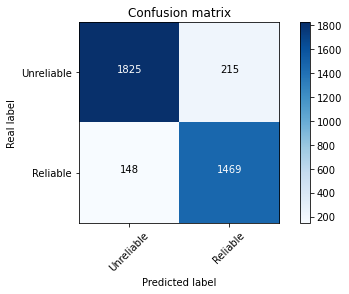

In [27]:
naive_bays.fit(X_train, y_train)
y_pred = naive_bays.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print ('Accuracy of this model is  %0.3f'  %accuracy)
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['Unreliable', 'Reliable'])

### Multinomial Classifier with Hyperparameter

In [28]:
naive_bays = MultinomialNB(alpha=0.1)

In [29]:
previous_score=0
for alpha in np.arange(0,1,0.1):
    sub_classifier=MultinomialNB(alpha=alpha)
    sub_classifier.fit(X_train,y_train)
    y_pred=sub_classifier.predict(X_test)
    score = metrics.accuracy_score(y_test, y_pred)
    if score>previous_score:
        naive_bays =sub_classifier
    print("Alpha: {}, Score : {}".format(alpha,score))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:512: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Alpha: 0.0, Score : 0.8930817610062893
Alpha: 0.1, Score : 0.9034727919059339
Alpha: 0.2, Score : 0.9034727919059339
Alpha: 0.30000000000000004, Score : 0.9048400328137818
Alpha: 0.4, Score : 0.9037462400875034
Alpha: 0.5, Score : 0.9029258955427947
Alpha: 0.6000000000000001, Score : 0.9023789991796555
Alpha: 0.7000000000000001, Score : 0.9018321028165163
Alpha: 0.8, Score : 0.9010117582718075
Alpha: 0.9, Score : 0.9004648619086683


In [37]:
## Get Features names
feature_names = cv.get_feature_names()

In [40]:
naive_bays.coef_[0]

array([ -9.25623032,  -8.65941425,  -9.25623032, ..., -10.95082604,
        -8.77860276,  -9.48448897])

In [45]:
### Most Reliable news
sorted(zip(naive_bays.coef_[0], feature_names), reverse=True)[:20]

[(-3.959036031878875, 'trump'),
 (-4.270529163287433, 'hillari'),
 (-4.354893746226486, 'clinton'),
 (-4.882143282984558, 'elect'),
 (-5.1420164383912965, 'new'),
 (-5.258591467735782, 'video'),
 (-5.262345225897286, 'comment'),
 (-5.356941106530278, 'us'),
 (-5.373615106837348, 'war'),
 (-5.3820575377326305, 'hillari clinton'),
 (-5.412180297187739, 'fbi'),
 (-5.461429282195685, 'vote'),
 (-5.475292720497795, 'email'),
 (-5.552663338286333, 'world'),
 (-5.583293604234576, 'obama'),
 (-5.686985102786022, 'donald'),
 (-5.722096960062764, 'donald trump'),
 (-5.740126294580707, 'russia'),
 (-5.822243114544532, 'america'),
 (-5.842190584456296, 'presid')]

In [46]:
### Most Unreliable news
sorted(zip(naive_bays.coef_[0], feature_names))[:5000]

[(-10.950826039804086, 'abroad'),
 (-10.950826039804086, 'abus new'),
 (-10.950826039804086, 'abus new york'),
 (-10.950826039804086, 'act new'),
 (-10.950826039804086, 'act new york'),
 (-10.950826039804086, 'advic'),
 (-10.950826039804086, 'advis new'),
 (-10.950826039804086, 'advis new york'),
 (-10.950826039804086, 'afford care'),
 (-10.950826039804086, 'afford care act'),
 (-10.950826039804086, 'age new'),
 (-10.950826039804086, 'age new york'),
 (-10.950826039804086, 'agenda breitbart'),
 (-10.950826039804086, 'airbag'),
 (-10.950826039804086, 'aleppo new'),
 (-10.950826039804086, 'aleppo new york'),
 (-10.950826039804086, 'ali'),
 (-10.950826039804086, 'america breitbart'),
 (-10.950826039804086, 'america new york'),
 (-10.950826039804086, 'ami'),
 (-10.950826039804086, 'ami schumer'),
 (-10.950826039804086, 'amp'),
 (-10.950826039804086, 'announc new'),
 (-10.950826039804086, 'answer new'),
 (-10.950826039804086, 'anti abort'),
 (-10.950826039804086, 'applaud'),
 (-10.950826039

### Build GRU Neural Network

In [51]:
# GRU neural Network
gru_model = Sequential(name = 'gru_nn_model')
gru_model.add(layer = Embedding(input_dim = max_features, output_dim = 120, name = '1st_layer'))
gru_model.add(layer = GRU(units = 120, dropout = 0.2, 
                          recurrent_dropout = 0.2, recurrent_activation = 'relu', 
                          activation = 'relu', name = '2nd_layer'))
gru_model.add(layer = Dropout(rate = 0.4, name = '3rd_layer'))
gru_model.add(layer = Dense(units = 120, activation = 'relu', name = '4th_layer'))
gru_model.add(layer = Dropout(rate = 0.2, name = '5th_layer'))
gru_model.add(layer = Dense(units = len(set(y)), activation = 'softmax', name = 'output_layer'))
# compiling the model
gru_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [52]:
gru_model.summary()

Model: "gru_nn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1st_layer (Embedding)        (None, None, 120)         600000    
_________________________________________________________________
2nd_layer (GRU)              (None, 120)               87120     
_________________________________________________________________
3rd_layer (Dropout)          (None, 120)               0         
_________________________________________________________________
4th_layer (Dense)            (None, 120)               14520     
_________________________________________________________________
5th_layer (Dropout)          (None, 120)               0         
_________________________________________________________________
output_layer (Dense)         (None, 2)                 242       
Total params: 701,882
Trainable params: 701,882
Non-trainable params: 0
________________________________________________

In [53]:
gru_model_fit = gru_model.fit(X_train, y_train, epochs = 1)

458/458 [==============================] - 22213s 49s/step - loss: 0.6851 - accuracy: 0.5686
